<a href="https://colab.research.google.com/github/cakirataberk/msc_2025_ataberkcakir_thesis/blob/main/(EBM)_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Boosting Machine (EBM) From Scratch




In [1]:
pip install interpret

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.datasets import fetch_california_housing, load_breast_cancer

# The library we will benchmark against
from interpret.glassbox import ExplainableBoostingRegressor, ExplainableBoostingClassifier
from interpret import show

# Set a random seed for reproducibility
np.random.seed(42)

### The `ScratchEBM` Class


In [3]:
class ScratchEBM:
    """
    An Explainable Boosting Machine implemented from scratch for educational purposes.
    """
    def __init__(self, n_estimators=100, learning_rate=0.01, max_depth=1, max_bins=256, model_type='regression'):
        """
        Initialize the EBM.

        Args:
            n_estimators (int): The number of boosting rounds (i.e., trees per feature).
            learning_rate (float): The step size for each update.
            max_depth (int): The max depth of the decision trees (stumps). Should be kept low.
            max_bins (int): The number of bins to discretize continuous features.
            model_type (str): 'regression' or 'classification'.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.max_bins = max_bins
        self.model_type = model_type

        # These will be learned during fitting
        self.intercept_ = 0
        self.bin_edges_ = []
        self.feature_shapes_ = []
        self.feature_names_ = []

    def _discretize(self, X):
        """Converts continuous features into discrete bin indices."""
        X_binned = np.zeros_like(X, dtype=int)
        for i in range(X.shape[1]):
            # Use quantiles for more robust binning against outliers
            _, self.bin_edges_[i] = np.histogram(X[:, i], bins=self.max_bins)
            X_binned[:, i] = np.digitize(X[:, i], self.bin_edges_[i][1:-1])
        return X_binned

    def fit(self, X, y):
        """
        Train the EBM on the given data.

        The process works as follows:
        1. Initialize a baseline prediction (the mean for regression, log-odds for classification).
        2. Calculate the initial errors (residuals).
        3. Loop for `n_estimators` rounds:
           a. For each feature in a round-robin fashion:
              i. Train a shallow decision tree to predict the current residuals.
              ii. Add the tree's prediction (scaled by learning_rate) to the feature's shape function.
              iii. Update the residuals by subtracting the tree's prediction.
        """
        # Store feature names if available
        if hasattr(X, 'columns'):
            self.feature_names_ = X.columns
        else:
            self.feature_names_ = [f'feature_{i}' for i in range(X.shape[1])]

        n_features = X.shape[1]
        self.bin_edges_ = [None] * n_features

        # Discretize data and store bin edges
        X_binned = self._discretize(X)

        # 1. Initialize predictions and residuals
        if self.model_type == 'regression':
            self.intercept_ = np.mean(y)
            residuals = y - self.intercept_
        else: # classification
            # For classification, we model the log-odds
            # The residual is the gradient of the log-loss: y - sigmoid(log_odds)
            avg_prob = np.mean(y)
            self.intercept_ = np.log(avg_prob / (1 - avg_prob))
            current_log_odds = np.full(len(y), self.intercept_)
            residuals = y - (1 / (1 + np.exp(-current_log_odds)))

        # Initialize shape functions as lookup tables (one for each feature)
        self.feature_shapes_ = [np.zeros(self.max_bins) for _ in range(n_features)]

        # 2. Boosting loop
        for _ in range(self.n_estimators):
            # 3. Round-robin cycle through features
            for j in range(n_features):
                # a. Train a shallow tree on the current feature to predict residuals
                tree = DecisionTreeRegressor(max_depth=self.max_depth)
                # We use the binned data to train the tree.
                # This ensures the tree's splits align with our bins.
                X_j_binned = X_binned[:, j].reshape(-1, 1)
                tree.fit(X_j_binned, residuals)

                # Get the tree's prediction for each unique bin
                # This represents the update for our shape function
                unique_bins = np.unique(X_j_binned)
                update_values = tree.predict(unique_bins.reshape(-1, 1))

                # b. Update the shape function (our lookup table)
                self.feature_shapes_[j][unique_bins] += self.learning_rate * update_values

                # c. Update residuals so the next tree learns from the remaining error
                tree_preds = tree.predict(X_j_binned)
                residuals -= self.learning_rate * tree_preds

    def _predict_log_odds(self, X):
        """Internal method to get raw model scores (log-odds for classification)."""
        # Start with the baseline intercept for all samples
        predictions = np.full(X.shape[0], self.intercept_)

        # Digitize the new data using the bin edges learned during training
        X_binned = np.zeros_like(X, dtype=int)
        for i in range(X.shape[1]):
             X_binned[:, i] = np.digitize(X[:, i], self.bin_edges_[i][1:-1])

        # Sum the contributions from each feature's shape function
        for i in range(X.shape[1]):
            # For each sample, look up the learned value in the correct bin
            predictions += self.feature_shapes_[i][X_binned[:, i]]

        return predictions

    def predict(self, X):
        """Make predictions for regression tasks."""
        if self.model_type != 'regression':
            raise TypeError("Use 'predict_proba' for classification models.")
        return self._predict_log_odds(X)

    def predict_proba(self, X):
        """Predict class probabilities for classification tasks."""
        if self.model_type != 'classification':
            raise TypeError("Use 'predict' for regression models.")

        log_odds = self._predict_log_odds(X)
        # Apply the sigmoid function to convert log-odds to probabilities
        probs = 1 / (1 + np.exp(-log_odds))
        # Return probabilities for both classes [P(0), P(1)]
        return np.vstack([1 - probs, probs]).T

    def plot_shape_function(self, feature_idx):
        """Generates a plot for a single feature's learned shape function."""
        shape_function = self.feature_shapes_[feature_idx]
        bin_edges = self.bin_edges_[feature_idx]

        # Calculate the center of each bin for plotting
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        plt.figure(figsize=(10, 6))
        plt.plot(bin_centers, shape_function)
        plt.title(f'Shape Function for: {self.feature_names_[feature_idx]}')
        plt.xlabel(self.feature_names_[feature_idx])
        plt.ylabel('Contribution to Prediction (Log-Odds)')
        plt.grid(True)
        plt.show()

-----

## Benchmarking

Test my `ScratchEBM` against the `interpretML` library on both a regression and a classification task.


In [4]:
# 1. Load and split data
housing = fetch_california_housing(as_frame=True)
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure we use .values to pass NumPy arrays to our scratch model
X_train_np, X_test_np = X_train.values, X_test.values
y_train_np, y_test_np = y_train.values, y_test.values


In [12]:
X_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80
...,...,...,...,...,...,...,...,...
11284,6.3700,35.0,6.129032,0.926267,658.0,3.032258,33.78,-117.96
11964,3.0500,33.0,6.868597,1.269488,1753.0,3.904232,34.02,-117.43
5390,2.9344,36.0,3.986717,1.079696,1756.0,3.332068,34.03,-118.38
860,5.7192,15.0,6.395349,1.067979,1777.0,3.178891,37.58,-121.96


In [7]:
# 1. Load and split data
housing = fetch_california_housing(as_frame=True)
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure we use .values to pass NumPy arrays to our scratch model
X_train_np, X_test_np = X_train.values, X_test.values
y_train_np, y_test_np = y_train.values, y_test.values

# 2. Train and evaluate our ScratchEBM
print("--- ScratchEBM (Regression) ---")
scratch_ebm_reg = ScratchEBM(n_estimators=100, learning_rate=0.05, model_type='regression')
scratch_ebm_reg.fit(X_train_np, y_train_np)
preds_scratch = scratch_ebm_reg.predict(X_test_np)
rmse_scratch = np.sqrt(mean_squared_error(y_test_np, preds_scratch))
print(f"RMSE: {rmse_scratch:.4f}")

# 3. Train and evaluate interpretML's EBM (without interactions)
print("\n--- interpretML EBM (Regression) ---")
# Add interactions=0 for a fair comparison
iml_ebm_reg = ExplainableBoostingRegressor(random_state=42, interactions=0)
iml_ebm_reg.fit(X_train, y_train)
preds_iml = iml_ebm_reg.predict(X_test)
rmse_iml = np.sqrt(mean_squared_error(y_test, preds_iml))
print(f"RMSE: {rmse_iml:.4f}")

--- ScratchEBM (Regression) ---
RMSE: 0.7154

--- interpretML EBM (Regression) ---
RMSE: 0.5540


#### Visual Comparison of Shape Functions


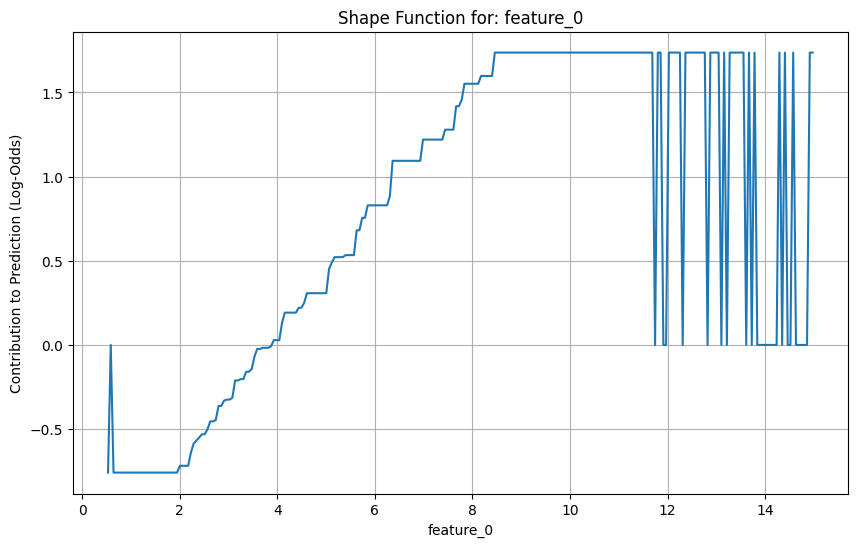

In [8]:
# Plot from our ScratchEBM
# Feature "MedInc" is at index 0
scratch_ebm_reg.plot_shape_function(feature_idx=0)

In [9]:
# Plot from interpretML
iml_ebm_reg_global = iml_ebm_reg.explain_global()
show(iml_ebm_reg_global)

**Observation:** The shape functions are remarkably similar\! Both models learned that as median income increases, its contribution to the predicted house price also increases, but the effect starts to plateau at higher income levels. Our from-scratch model successfully captured the non-linear relationship.

-----

### Classification Task: Breast Cancer Diagnosis



In [13]:
# 1. Load and split data
cancer = load_breast_cancer(as_frame=True)
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure we use .values to pass NumPy arrays to our scratch model
X_train_np, X_test_np = X_train.values, X_test.values
y_train_np, y_test_np = y_train.values, y_test.values

# 2. Train and evaluate our ScratchEBM
print("--- ScratchEBM (Classification) ---")
scratch_ebm_clf = ScratchEBM(n_estimators=100, learning_rate=0.05, model_type='classification')
scratch_ebm_clf.fit(X_train_np, y_train_np)
probs_scratch = scratch_ebm_clf.predict_proba(X_test_np)
loss_scratch = log_loss(y_test_np, probs_scratch)
print(f"LogLoss: {loss_scratch:.4f}")

# 3. Train and evaluate interpretML's EBM (without interactions)
print("\n--- interpretML EBM (Classification) ---")
# Add interactions=0 for a fair comparison
iml_ebm_clf = ExplainableBoostingClassifier(random_state=42, interactions=0)
iml_ebm_clf.fit(X_train, y_train)
probs_iml = iml_ebm_clf.predict_proba(X_test)
loss_iml = log_loss(y_test, probs_iml)
print(f"LogLoss: {loss_iml:.4f}")

--- ScratchEBM (Classification) ---
LogLoss: 0.5094

--- interpretML EBM (Classification) ---
LogLoss: 0.0790


#### Visual Comparison of Shape Functions



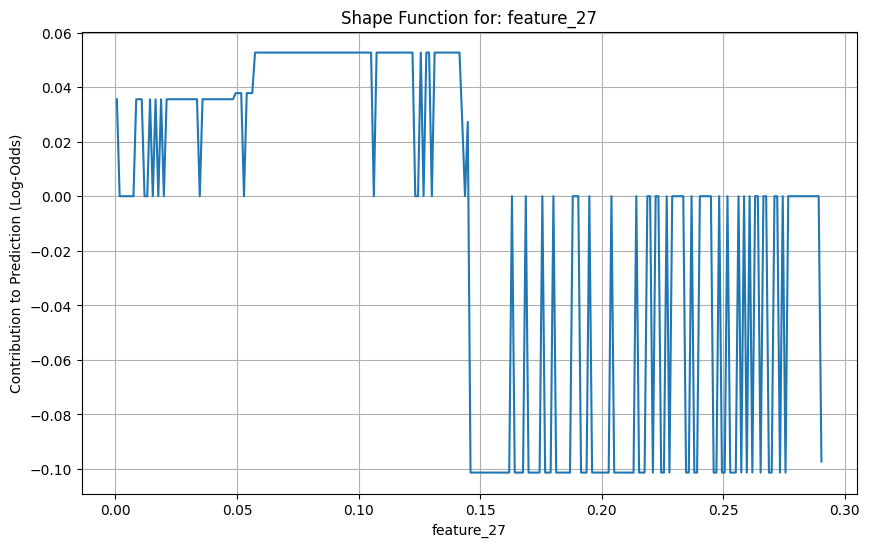

In [14]:
# Plot from our ScratchEBM
# The feature is at index 27
worst_concave_points_idx = X_train.columns.get_loc('worst concave points')
scratch_ebm_clf.plot_shape_function(feature_idx=worst_concave_points_idx)

In [15]:
# Plot from interpretML
iml_ebm_clf_global = iml_ebm_clf.explain_global()
show(iml_ebm_clf_global)

**Observation:** Again, the general shapes are very consistent. Both models learned that a low value for "worst concave points" strongly decreases the log-odds (predicting benign), while a higher value significantly increases the log-odds (predicting malignant).

-----

## Section 4: Conclusion



**Why is the library version still better?** The `interpretML` library is a production-grade tool with many optimizations that our  version lacks, such as:

  * **Performance:** It's written with highly optimized code (often C++) for speed.
  * **Advanced Techniques:** It uses more sophisticated binning strategies and.
  * **Robustness:** It includes many more checks, edge-case handling, and engineering features that make it more reliable.
